# Example 4a: Fermionic single impurity model

## Example of the Fermionic HEOM solver

Here we model a single fermion coupled to two electronic leads or reservoirs (e.g.,  this can describe a single quantum dot, a molecular transistor, etc).  Note that in this implementation we primarily follow the definitions used by Christian Schinabeck in his Dissertation https://opus4.kobv.de/opus4-fau/files/10984/DissertationChristianSchinabeck.pdf and related publications.


Notation:  
$K=L/R$ refers to  left or right leads.

$\sigma=\pm$ refers to input/output


We choose a Lorentzian spectral density for the leads, with a peak at the chemical potential. The latter simplifies a little the notation required for the correlation functions, but can be relaxed if neccessary.

$$J(\omega) = \frac{\Gamma  W^2}{((\omega-\mu_K)^2 +W^2 )}$$


Fermi distribution is

$$f_F (x) = (\exp(x) + 1)^{-1}$$

gives correlation functions

$$C^{\sigma}_K(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega e^{\sigma i \omega t} \Gamma_K(\omega) f_F[\sigma\beta(\omega - \mu)]$$


As with the Bosonic case we can treat these with Matsubara, Pade, or fitting approaches.

The Pade decomposition approximates the Fermi distubition as 

$$f_F(x) \approx f_F^{\mathrm{approx}}(x) = \frac{1}{2} - \sum_l^{l_{max}} \frac{2k_l x}{x^2 + \epsilon_l^2}$$

$k_l$ and $\epsilon_l$ are co-efficients defined in J. Chem Phys 133,10106

Evaluating the integral for the correlation functions gives,


$$C_K^{\sigma}(t) \approx \sum_{l=0}^{l_{max}} \eta_K^{\sigma_l} e^{-\gamma_{K,\sigma,l}t}$$

where

$$\eta_{K,0} = \frac{\Gamma_KW_K}{2} f_F^{approx}(i\beta_K W)$$

$$\gamma_{K,\sigma,0} = W_K - \sigma i\mu_K$$ 

$$\eta_{K,l\neq 0} = -i\cdot \frac{k_m}{\beta_K} \cdot \frac{\Gamma_K W_K^2}{-\frac{\epsilon^2_m}{\beta_K^2} + W_K^2}$$

$$\gamma_{K,\sigma,l\neq 0}= \frac{\epsilon_m}{\beta_K} - \sigma i \mu_K$$

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *

In [25]:
import contextlib
import time

import numpy as np

from qutip import *
from qutip.nonmarkov.heom import HEOMSolver
from qutip.nonmarkov.heom import FermionicBath
from qutip.nonmarkov.heom import LorentzianBath
from qutip.nonmarkov.heom import LorentzianPadeBath
from scipy.integrate import quad

In [3]:
#Define parameters and plot lead spectra

Gamma = 0.01  #coupling strength
W=1. #cut-off
T = 0.025851991 #temperature
beta = 1./T

theta = 2. #Bias
mu_l = theta/2.
mu_r = -theta/2.

w_list = np.linspace(-2,2,100)

def Gamma_L_w(w):
    return Gamma*W**2/((w-mu_l)**2 + W**2)

def Gamma_R_w(w):
    return Gamma*W**2/((w-mu_r)**2 + W**2)


def f(x):
    kB=1.
    return 1/(exp(x)+1.)
def f2(x):
    return 0.5

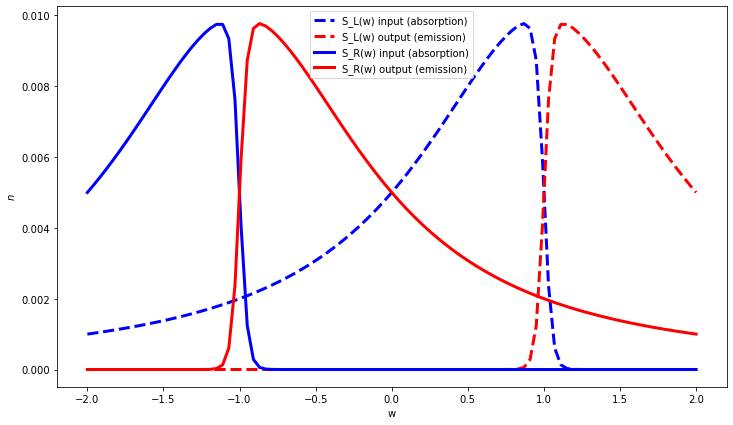

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 7))
gam_list_in = [Gamma_L_w(w)*f(beta*(w-mu_l)) for w in w_list]

ax1.plot(w_list,gam_list_in, "b--", linewidth=3, label= r"S_L(w) input (absorption)")


ax1.set_xlabel("w")
ax1.set_ylabel(r"$S(\omega)$")
ax1.legend()


gam_list_out = [Gamma_L_w(w)*f(-beta*(w-mu_l)) for w in w_list]
spec = [Gamma_L_w(w) for w in w_list]

ax1.plot(w_list,gam_list_out, "r--", linewidth=3, label= r"S_L(w) output (emission)")


gam_list_in = [Gamma_R_w(w)*f(beta*(w-mu_r)) for w in w_list]

ax1.plot(w_list,gam_list_in, "b", linewidth=3, label= r"S_R(w) input (absorption)")




gam_list_out = [Gamma_R_w(w)*f(-beta*(w-mu_r)) for w in w_list]
spec = [Gamma_R_w(w) for w in w_list]

ax1.plot(w_list,gam_list_out, "r", linewidth=3, label= r"S_R(w) output (emission)")
ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()

In [37]:
#heom simulation with above params (Pade)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

#Single fermion.
d1 = destroy(2)

#Site energy
e1 = 1. 


H0 = e1*d1.dag()*d1 

Nk = 10
Ncc = 2  #For a single impurity we converge with Ncc = 2

Q=d1
#bath = FermionicBath(Q, ck_plus, vk_plus, ck_minus, vk_minus)

bathL = LorentzianPadeBath(Q,Gamma,W,mu_l,T,Nk,tag="L")
bathR = LorentzianPadeBath(Q,Gamma,W,mu_r,T,Nk,tag="R")
        # for a single impurity we converge with max_depth = 2
resultHEOMP = HEOMSolver(H0, [bathL,bathR], 2, options=options)

In [40]:
rho_0 = basis(2,0)*basis(2,0).dag()


rhossP,fullssP=resultHEOMP.steady_state()


In [41]:
rho_0 = basis(2,0)*basis(2,0).dag()
tlist = np.linspace(0,100,1000)
out1P = resultHEOMP.run(rho_0,tlist,ado_return=True)

First we plot the decay of an initiall excited impurity. This is not very illuminating.

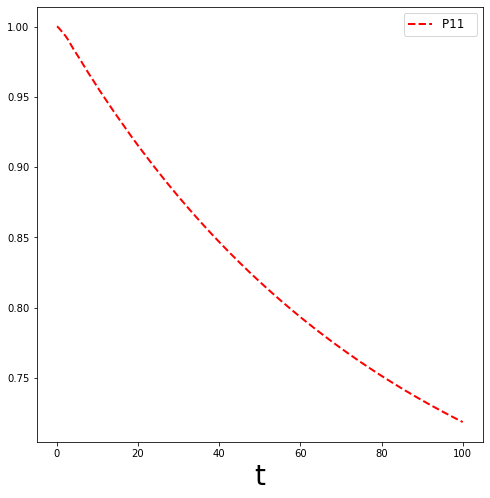

In [42]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(tlist, expect(out1P.states,rho_0), 'r--', linewidth=2, label="P11  ")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

In [43]:
#heom simu on above params (Matsubara)


#heom simulation with above params (Pade)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

#Single fermion.
d1 = destroy(2)

#Site energy
e1 = 1. 


H0 = e1*d1.dag()*d1 

Nk = 10
Ncc = 2  #For a single impurity we converge with Ncc = 2

Q=d1
#bath = FermionicBath(Q, ck_plus, vk_plus, ck_minus, vk_minus)

bathL = LorentzianBath(Q,Gamma,W,mu_l,T,Nk,tag="L")
bathR = LorentzianBath(Q,Gamma,W,mu_r,T,Nk,tag="R")
        # for a single impurity we converge with max_depth = 2
resultHEOMM = HEOMSolver(H0, [bathL,bathR], Ncc, options=options)

In [47]:
out1M = resultHEOMM.run(rho_0,tlist,ado_return=True)

In [45]:
rhossHM,fullssM = resultHEOMM.steady_state()

We see a marked difference in the Matsubara vs Pade approach.

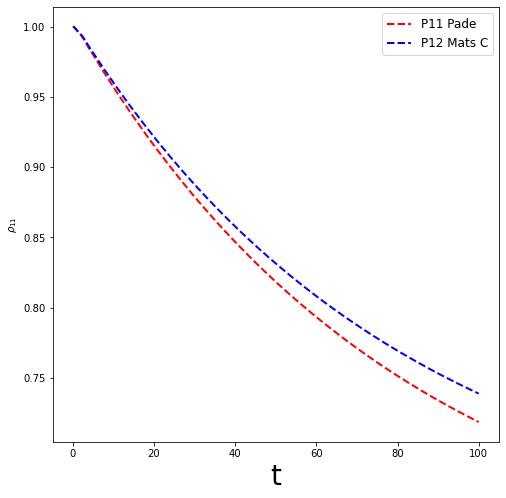

In [48]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(tlist, expect(out1P.states,rho_0), 'r--', linewidth=2, label="P11 Pade ")


axes.plot(tlist, expect(out1M.states,rho_0), 'b--', linewidth=2, label="P12 Mats C")

axes.set_ylabel(r"$\rho_{11}$")
axes.set_xlabel(r't', fontsize=28)


axes.legend(loc=0, fontsize=12)

One advantage of this simple model is the current is analytically solvable, so we can check convergence of the result
See the paper for a detailed description and references.

In [60]:
def Gamma_w(w, mu):
    return Gamma*W**2/((w-mu)**2 + W**2)

def CurrFunc():
    def lamshift(w,mu):
        return (w-mu)*Gamma_w(w,mu)/(2*W)
    integrand = lambda w: ((2/(pi))*Gamma_w(w,mu_l)*Gamma_w(w,mu_r)*(f(beta*(w-mu_l))-f(beta*(w-mu_r))) /
            ((Gamma_w(w,mu_l)+Gamma_w(w,mu_r))**2 +4*(w-e1 - lamshift(w,mu_l)-lamshift(w,mu_r))**2))
    def real_func(x):
        return real(integrand(x))
    def imag_func(x):
        return imag(integrand(x))

    #in principle the bounds should be checked if parameters are changed
    a= -2
    b=2
    real_integral = quad(real_func, a, b)
    imag_integral = quad(imag_func, a, b)
    
   

    return real_integral[0] + 1.0j * imag_integral[0]
    
curr_ana = CurrFunc()
print(curr_ana)

(0.0008130726698759556+0j)


In [65]:

def state_current(ado_state,bath_tag):
        level_1_aux = [
            (ado_state.extract(label), ado_state.exps(label)[0])
            for label in ado_state.filter(level=1,tags =[bath_tag])
        ]
        def exp_sign(exp):
            return 1 if exp.type == exp.types["+"] else -1

        def exp_op(exp):
            return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

        k = Nk + 1
        return -1.0j * sum(
            exp_sign(exp) * (exp_op(exp) * aux).tr()
            for aux, exp in level_1_aux         
        )
        
currP = state_current(fullssP,"R")
print(currP)
#The sum of the currents in the steadystate = 0
print(state_current(fullssP,"L")+state_current(fullssP,"R"))

(0.0008130302805827144+5.421010862427522e-20j)
(-1.0842021724855044e-19+1.6263032587282567e-19j)


/tmp/ipykernel_5834/2194045410.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -1.0j * sum(


In [62]:


def state_current(ado_state,bath_tag):
        level_1_aux = [
            (ado_state.extract(label), ado_state.exps(label)[0])
            for label in ado_state.filter(level=1,tags =[bath_tag])
        ]
        def exp_sign(exp):
            return 1 if exp.type == exp.types["+"] else -1

        def exp_op(exp):
            return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

        k = Nk + 1
        return -1.0j * sum(
            exp_sign(exp) * (exp_op(exp) * aux).tr()
            for aux, exp in level_1_aux         
        )
        
currM = state_current(fullssM,"R")
print(currM)
   

(0.0011018485316349562-0j)


/tmp/ipykernel_5834/349278954.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -1.0j * sum(


In [63]:
print("Pade current", currP)
print("Matsubara current", currM)
print("Analytical curernt", curr_ana)

Pade current (0.0008130302805827144+5.421010862427522e-20j)
Matsubara current (0.0011018485316349562-0j)
Analytical curernt (0.0008130726698759556+0j)


We see that the Matsubara example is far from converged.
Now lets plot the current as a function of bias voltage.

In [24]:
start=time.time()

currPlist = []
curranalist = []

theta_list = linspace(-4,4,100)

for theta in theta_list:
    mu_l = theta/2.
    mu_r = -theta/2.
    #Pade cut-off
    lmax = 10




    d1 = destroy(2)

    e1 = .3


    H0 = e1*d1.dag()*d1 


    Qops = [d1.dag(),d1,d1.dag(),d1]


    rho_0 = basis(2,0)*basis(2,0).dag()

    Kk=lmax+1
    Ncc = 2

    tlist = np.linspace(0,100,1000)


    eta_list = [etapR,etamR,etapL,etamL]


    gamma_list = [gampR,gammR,gampL,gammL]

    resultHEOM = FermionicHEOMSolver(H0, Qops,  eta_list, gamma_list, Ncc)
    
    rho_0 = basis(2,0)*basis(2,0).dag()
    rhossHP,fullssP=resultHEOM.steady_state() 

    


    
        #we can extract the current from the auxiliary ADOs calculated in the steady state

    aux_1_list_list=[]
    aux1_indices_list=[]
    aux_2_list_list=[]
    aux2_indices_list=[]


    K = Kk  

    shape = H0.shape[0]
    dims = H0.dims



    aux_1_list, aux1_indices, idx2state = get_aux_matrices([fullssP], 1, 4, K, Ncc, shape, dims)
    aux_2_list, aux2_indices, idx2state = get_aux_matrices([fullssP], 2, 4, K, Ncc, shape, dims)


    d1 = destroy(2)   #Kk to 2*Kk
    currP = -1.0j * (((sum([(d1*aux_1_list[gg][0]).tr() for gg in range(Kk,2*Kk)]))) - ((sum([(d1.dag()*aux_1_list[gg][0]).tr() for gg in range(Kk)]))))


    curr_ana = CurrFunc()
    
    currPlist.append(currP)
    curranalist.append(curr_ana)
 
end=time.time()

print("run time", end-start)

run time 183.41681957244873


In [75]:
start=time.time()

currPlist = []
curranalist = []

theta_list = linspace(-4,4,100)

for theta in theta_list:
    mu_l = theta/2.
    mu_r = -theta/2.
    #Pade cut-off
    Nk = 10

    d1 = destroy(2)
    Q = d1
    
    


    e1 = 0.3


    H0 = e1*d1.dag()*d1 

    bathL = LorentzianPadeBath(Q,Gamma,W,mu_l,T,Nk,tag="L")
    bathR = LorentzianPadeBath(Q,Gamma,W,mu_r,T,Nk,tag="R")
        # for a single impurity we converge with max_depth = 2
    resultHEOM2 = HEOMSolver(H0, [bathL,bathR], 2, options=options)
    
    rhossHP,fullssP=resultHEOM2.steady_state() 


    def state_current(ado_state,bath_tag):
        level_1_aux = [
            (ado_state.extract(label), ado_state.exps(label)[0])
            for label in ado_state.filter(level=1,tags =[bath_tag])
        ]
        def exp_sign(exp):
            return 1 if exp.type == exp.types["+"] else -1

        def exp_op(exp):
            return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

        k = Nk + 1
        return -1.0j * sum(
            exp_sign(exp) * (exp_op(exp) * aux).tr()
            for aux, exp in level_1_aux         
        )

    currP = state_current(fullssP,"R") 
    #print(currP)

    curr_ana = CurrFunc()
    
    currPlist.append(currP)
    curranalist.append(curr_ana)
 
end=time.time()

print("run time", end-start)

/tmp/ipykernel_5834/1510444643.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -1.0j * sum(


run time 30.83386540412903


In [67]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 28
matplotlib.rcParams['ytick.labelsize'] = 28
matplotlib.rcParams['legend.fontsize'] = 28
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXgeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams['text.usetex'] = False

/home/neill/anaconda3/envs/bofinexamples/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/neill/anaconda3/envs/bofinexamples/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


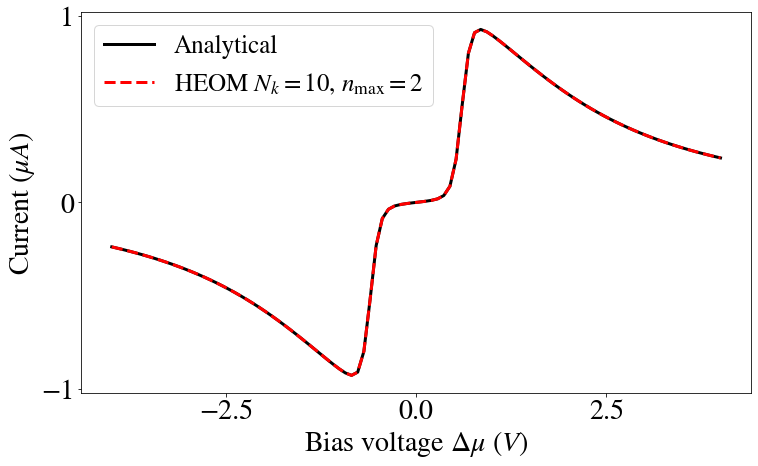

In [77]:
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.plot(theta_list,2.434e-4*1e6*array(curranalist), color="black", linewidth=3, label= r"Analytical")
ax1.plot(theta_list,2.434e-4*1e6*array(currPlist), 'r--', linewidth=3, label= r"HEOM $N_k=10$, $n_{\mathrm{max}}=2$")


ax1.locator_params(axis='y', nbins=4)
ax1.locator_params(axis='x', nbins=4)

axes.set_xticks([-2.5,0.,2.5])
axes.set_xticklabels([-2.5,0,2.5]) 
ax1.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)",fontsize=28)
ax1.set_ylabel(r"Current ($\mu A$)",fontsize=28)
ax1.legend(fontsize=25)

fig.savefig("figImpurity.pdf")